# **AvStats - Flight Delay Forecast**

*Iraia Torres, October 2024*

This project aims to develop a forecasting model for commercial flight delays. The objective is to analyze historical flight data and investigate how delays are influenced by factors such as flight routes, weather conditions, and passenger volumes. The expected outcome is to generate daily or weekly predictions of flight delays.

The project includes two main Jupyter notebooks that go through data preparation, EDA, and model development.

### **Notebook 2 - Predictive Models**
**Note**: *Run the EDA pipeline or notebook before*

This notebook includes feature engineering, ML model training, and performance evaluation.

1. Machine Learning Regression Models
    * Linear Regression
    
    * Decision Tree
      
    * Random Forest
    
    * Support Vector Regression (SVR)
      
    * Gradient Boosting Machines (GBM)
      
    * XGBoost
    
    * Neural Networks
    
2. Statistical Time-Series Models
    * ARIMA. Determine d (I), p & q (AR and MA)
    
    * SARIMAX
    
    * Rolling Forecast Origin
    
    * Prophet 
    
3. Evaluation Methods
    * Data Validation (Cross-Validation)
    
    * Learning Curve Pipeline
    
    * Prediction Accuracy

    * Residual Analysis

    * Comparison of Methods

In [1]:
import os
from datetime import datetime
from core.ML.ModelSummary import modelling_summary
from core.ML.TimeSeriesAnalysis import TimeSeriesAnalysis
from core.ML.NeuralNetworks import nn_plots, NeuralNetworks
from core.ML.ModelPipeline import ModelPipeline
from core.ML.ModelEvaluation import *
from core.ML.ResidualAnalysis import ResidualAnalysis

import logging
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

##### **Explanation of Different Dataframes**

Meaning of the different dataframes used through the modelling and predictions.
* **df_original**. Original 2023 flight schedule dataset with cleaned data and new features | **340k rows**; one for each flight | **ML Models**
* **df_weather_daily**. Flights are grouped daily per route | **75k rows**; one for each day per route | **Neural Networks**
* **df_passengers_vif**. Same as *df_passengers_monthly* after feature selection | **756 rows**; one per month per route | **ML Models**
* **df_BRU_MAD**. Same as *df_weather_encoded* but with just 1 route | **364 rows**; one per day | **ARIMA/SARIMAX/Rolling Forecast**

In [2]:
# Load the DataFrames for ML
df_vif_original = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_vif_original.csv"))
df_vif_weather = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_vif_weather.csv"))
df_vif_passengers = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_vif_passengers.csv"))
df_vif_BRU_MAD = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_vif_BRU_MAD.csv"))

df_filtered_original = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_filtered_original.csv"))
df_filtered_weather = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_filtered_weather.csv"))
df_filtered_passengers = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_filtered_passengers.csv"))
df_filtered_BRU_MAD = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_filtered_BRU_MAD.csv"))

# Load the DataFrames for NN
#df_scaled_original = pd.read_csv(os.path.join("..", r"data\data_for_nn", "df_scaled_original.csv"))
#df_scaled_weather = pd.read_csv(os.path.join("..", r"data\data_for_nn", "df_scaled_weather.csv"))

#df_scaled_BRU_MAD = pd.read_csv(os.path.join("..", r"data\data_for_nn", "df_scaled_BRU_MAD.csv"))
#df_scaled_passengers = pd.read_csv(os.path.join("..", r"data\data_for_nn", "df_scaled_passengers.csv"))

# Target Variables
#target_variable_original = pd.read_csv(os.path.join("..", r"data\data_for_nn", "target_variable_original.csv"))
#target_variable_weather = pd.read_csv(os.path.join("..", r"data\data_for_nn", "target_variable_weather.csv"))
#target_variable_BRU_MAD = pd.read_csv(os.path.join("..", r"data\data_for_nn", "target_variable_BRU_MAD.csv"))
#target_variable_passengers = pd.read_csv(os.path.join("..", r"data\data_for_nn", "target_variable_passengers.csv"))

# Load the DataFrames for Time-Series
df_BRU_MAD_daily = pd.read_csv(os.path.join("..", r"data\data_for_time_series", "df_BRU_MAD_daily.csv"))

print("DataFrames loaded successfully")

DataFrames loaded successfully


### **1. Machine Learning Models**

- If predicting flight delays based only on past delays → Prophet or SARIMAX
- If including weather, passengers, and route details → Machine Learning (XGBoost, GBM)
- For best accuracy → Combine time-series forecasting + ML models


In [3]:
dataframes = [
    (df_filtered_original, 'dep_delay'),
    (df_filtered_weather, 'total_dep_delay'),
    (df_filtered_passengers, 'total_dep_delay'),
    (df_filtered_BRU_MAD, 'total_dep_delay'),
]
titles = ["Original Data", "With Weather", "With Weather & Passengers; Monthly", "BRU-MAD With Weather"]
evaluation_results = []

#### **1.1. Linear Regression**
First, linear regression will be used since it provides a **quick initial understanding** of the relationship between the predictors (independent) and the target variable (dependent). It's useful to detect **multicollinearity** (correlation between features) and to see if a **simple model** is enough to get good results before moving to complex ones.

**sm summary variables**
* **Dep. Variable**. The dependent variable we want to predict (it's total_dep_delay).
* **Model**. The type of model used, which is OLS (Ordinary Least Squares).
* **Method**. Least Squares, which is the standard approach for fitting a linear regression model.
* **No. Observations**. There are 604 data points (rows) in the dataset.
* **Df Residuals**. The degrees of freedom for residuals (observations minus the number of estimated parameters). Here, it's 586.
* **Df Model**. The degrees of freedom for the model (the number of predictors), which is 17 (including the intercept).

**Metrics**
* **MAPE**
    * **< 5%** is considered as an indication that the forecast is acceptably accurate.
    * **10% - 25%** indicates low, but acceptable accuracy.
    * **> 25%** very low accuracy.

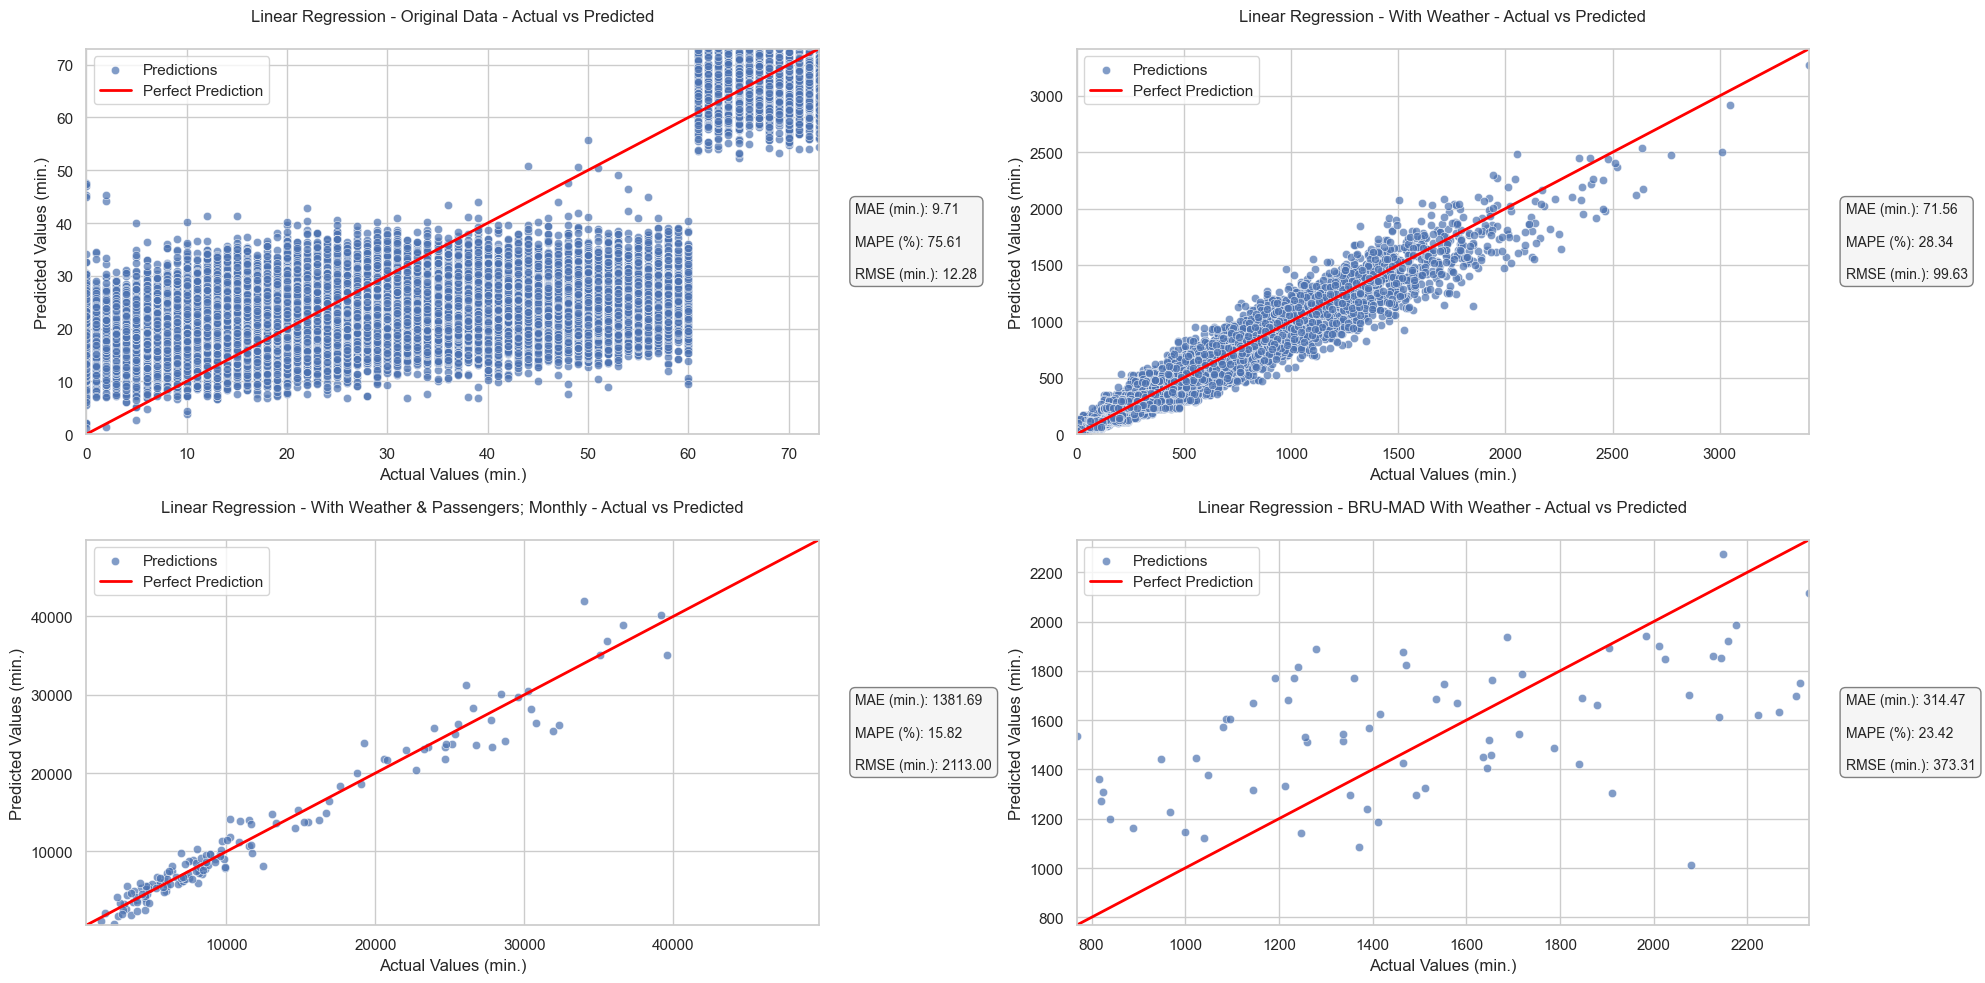

,Dataset,Model,MAE (min.),MAPE (%),RMSE (min.),Mean CV R2,Std CV R2,CV Scores
0,Original Data,Linear Regression,9.71,75.61,12.28,0.324616,0.003775,"[0.3256816994199817, 0.330723548260644, 0.3189..."
1,With Weather,Linear Regression,71.56,28.34,99.63,0.930287,0.001834,"[0.9288840880516298, 0.9311033806648199, 0.933..."
2,With Weather & Passengers; Monthly,Linear Regression,1381.69,15.82,2113.00,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
3,BRU-MAD With Weather,Linear Regression,314.47,23.42,373.31,0.118162,0.115031,"[0.003459132642272267, 0.1490610945873223, 0.1..."


In [13]:
# Train and evaluate
linear_regression_summary, linear_regression_metrics, linear_regression_models = modelling_summary(dataframes, titles, ["Linear Regression"])
linear_regression_summary

In [14]:
# Access the best trained model for "Original Data"
model_info = linear_regression_models["Original Data"]
model_name = model_info["Model Name"]
trained_model = model_info["Trained Model"]
rmse = model_info["Best RMSE"]

print(f"Best model for Original Data: {model_name} (RMSE: {rmse:.2f})")

Best model for Original Data: Linear Regression (RMSE: 12.28)


In [15]:
linear_regression_metrics_weather = linear_regression_metrics["With Weather & Passengers; Monthly"]["Linear Regression"]
evaluation_results.append({"Model": "Linear Regression", **linear_regression_metrics_weather})

**Results**

**df_vif_original**
* The high percentage errors show that the predictions are **not reliable**, suggesting that the dataset lacks critical predictors of delay.

**df_vif_weather**
* Incorporating weather data **improves** the model, as MAPE and Mean CV R2 (0.80) are better. Daily data provides good predictions for operational decision-making since it takes into account short-term variations like weather conditions.

**df_vif_passengers**
* Adding passenger data and the monthly aggregation **improves** the model, as MAPE and Mean CV R2 (0.92) are better. This means the model captures better trends but is not as precise in predicting daily flight delays. In conclusion, including passenger data in monthly data adds context but **does not improve day-to-day predictive capability**.

**df_vif_BRU_MAD**
* The predictions have higher variation and therefore are **less reliable** compared to the weather-based model. This happens due to fewer data points.

**Interpretation**

* Daily datasets (df_vif_weather and df_vif_BRU_MAD) have **lower error** rates but might be more **sensitive to noise** or short-term fluctuations.
* Monthly dataset (df_vif_passengers) has **higher absolute errors**, but it's better at capturing **long-term trends** and is more **consistent in cross-validation** (higher Mean CV R² and CV Scores).

The performance of daily datasets tent to fluctuate more. This comes from how models work with more detailed data (the daily data points). Daily changes are harder to predict consistently, which leads to higher fluctuations in error through different fragments of the data. 

On the other hand, monthly data tends to show more stable patterns, making model performance more reliable and with fewer fluctuations. This does not mean daily datasets are worse; they just need a more careful handling of the fluctuations.

#### **1.2. Decision Tree**

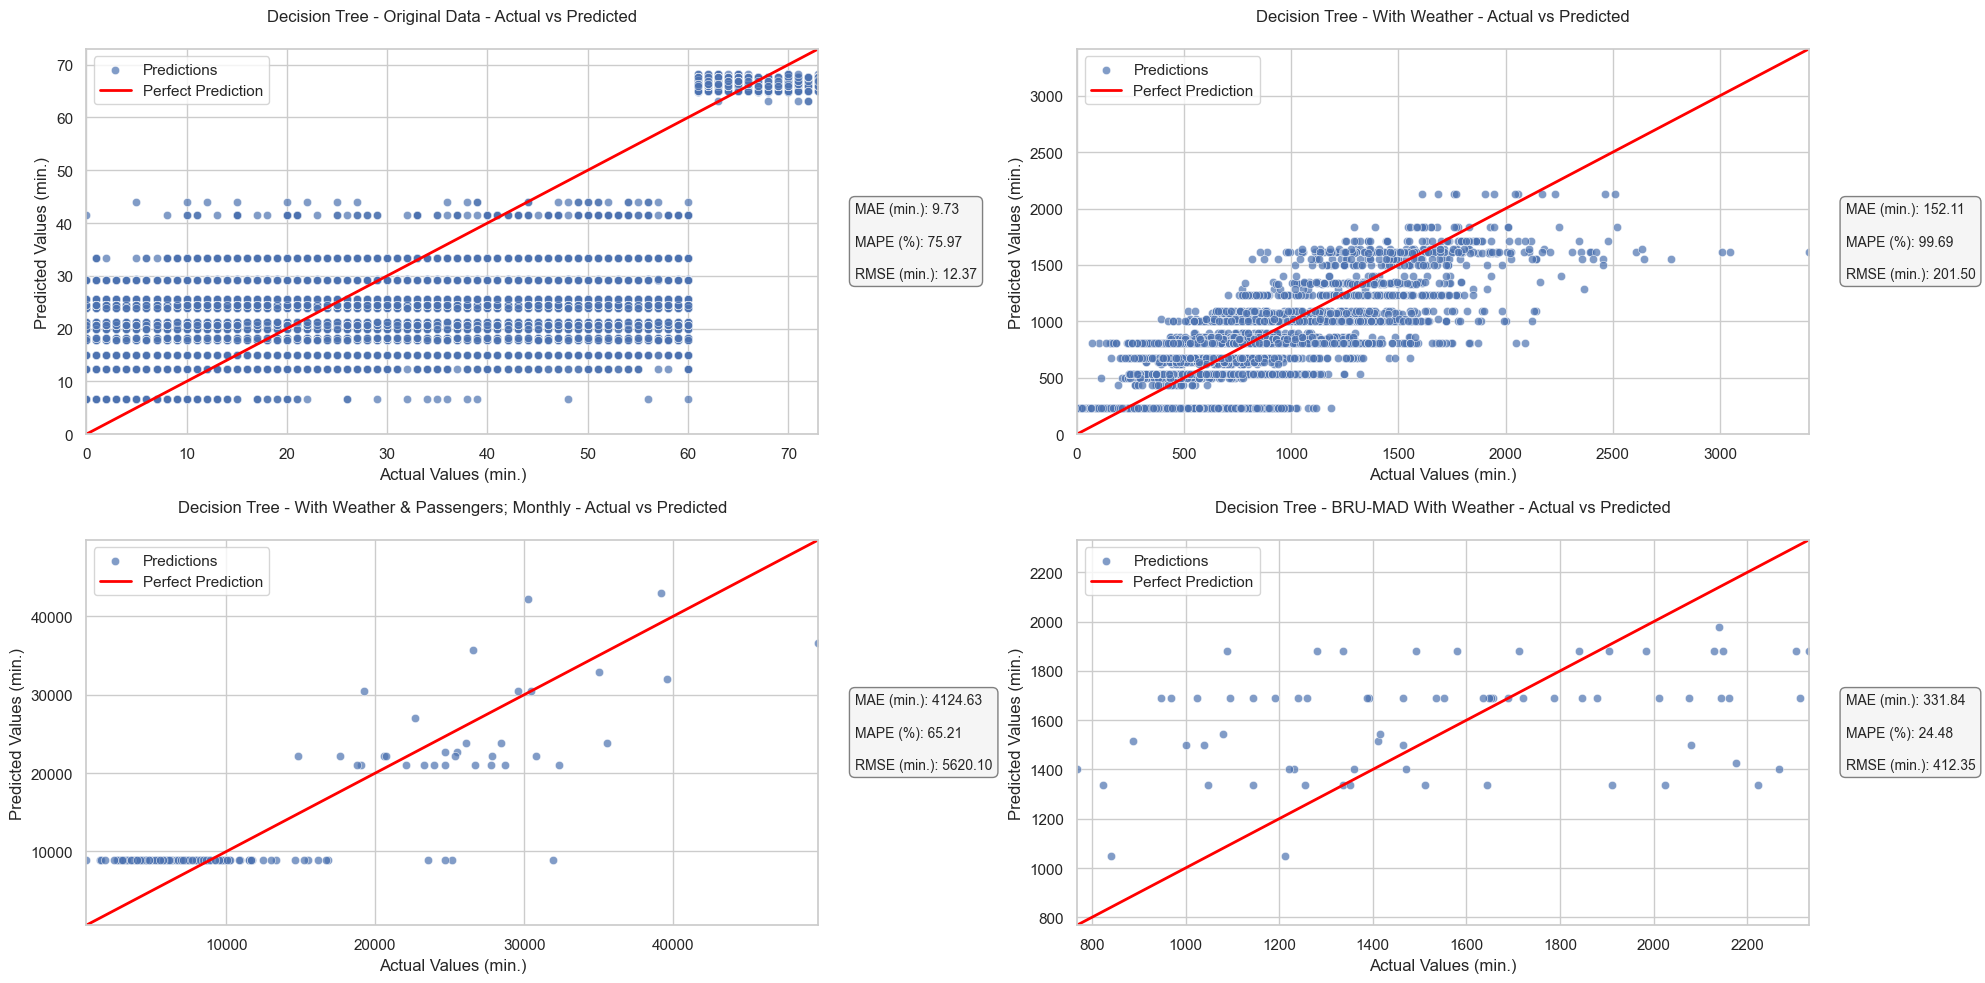

,Dataset,Model,MAE (min.),MAPE (%),RMSE (min.),Mean CV R2,Std CV R2,CV Scores
0,Original Data,Decision Tree,9.73,75.97,12.37,0.324616,0.003775,"[0.3256816994199817, 0.330723548260644, 0.3189..."
1,With Weather,Decision Tree,152.11,99.69,201.50,0.930287,0.001834,"[0.9288840880516298, 0.9311033806648199, 0.933..."
2,With Weather & Passengers; Monthly,Decision Tree,4124.63,65.21,5620.10,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
3,BRU-MAD With Weather,Decision Tree,331.84,24.48,412.35,0.118162,0.115031,"[0.003459132642272267, 0.1490610945873223, 0.1..."


In [17]:
# Train and evaluate
decision_model_summary, decision_model_metrics, decision_models = modelling_summary(dataframes, titles, ["Decision Tree"])
decision_model_summary

In [18]:
decision_model_metrics_weather = decision_model_metrics["With Weather & Passengers; Monthly"]["Decision Tree"]
evaluation_results.append({"Model": "Decision Tree", **decision_model_metrics_weather})

In [8]:
"""# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(decision_model, feature_names=x.columns, filled=True, rounded=True, fontsize=10)
plt.show()

# Export the decision tree structure as text
print(export_text(decision_model, feature_names=list(x.columns)))"""

'# Visualize the decision tree\nplt.figure(figsize=(12, 8))\nplot_tree(decision_model, feature_names=x.columns, filled=True, rounded=True, fontsize=10)\nplt.show()\n\n# Export the decision tree structure as text\nprint(export_text(decision_model, feature_names=list(x.columns)))'

#### **1.3. Random Forest**

In [20]:
rf_dataframes = [
    (df_filtered_weather, 'total_dep_delay'),
    (df_filtered_passengers, 'total_dep_delay'),
]
rf_titles = ["With Weather", "With Weather & Passengers; Monthly"] 

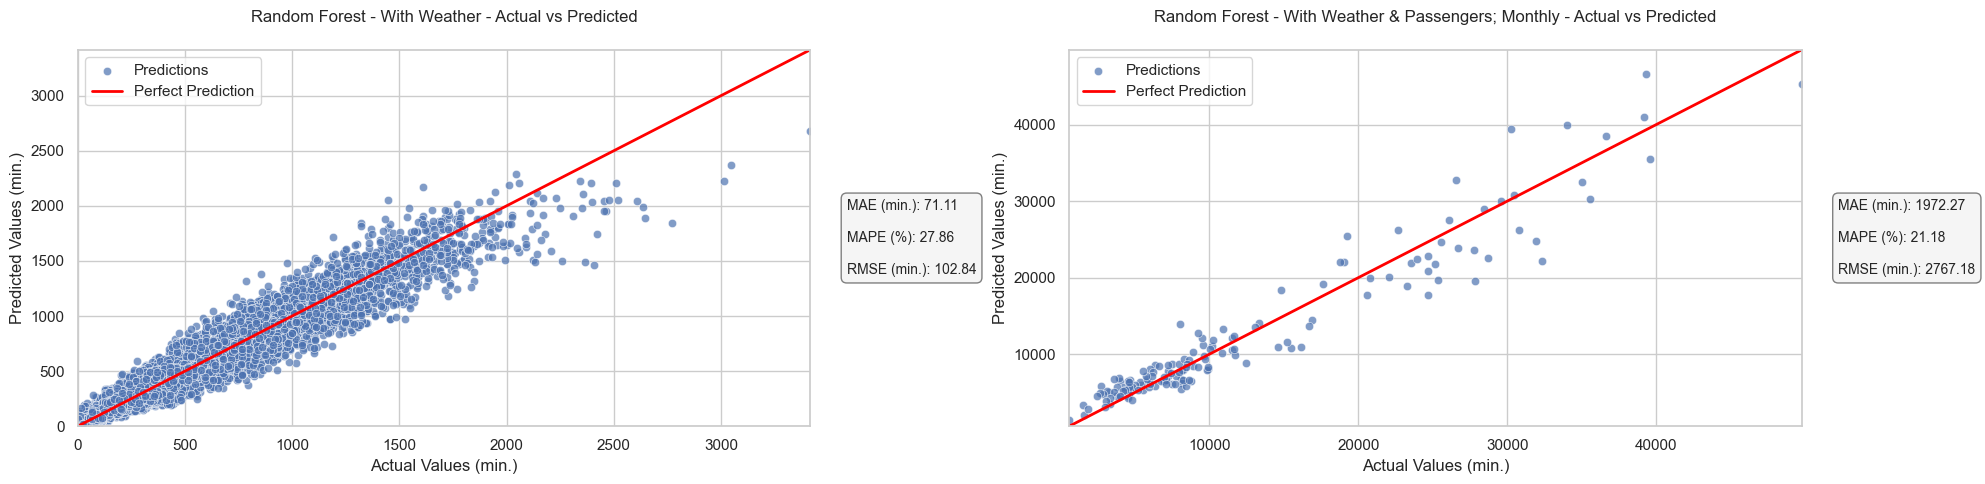

,Dataset,Model,MAE (min.),MAPE (%),RMSE (min.),Mean CV R2,Std CV R2,CV Scores
0,With Weather,Random Forest,71.11,27.86,102.84,0.930287,0.001834,"[0.9288840880516298, 0.9311033806648199, 0.933..."
1,With Weather & Passengers; Monthly,Random Forest,1972.27,21.18,2767.18,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."


In [21]:
# Train and evaluate
random_forest_summary, random_forest_metrics, random_forest_models = modelling_summary(rf_dataframes, rf_titles, ["Random Forest"])
random_forest_summary

In [22]:
random_forest_metrics_weather = random_forest_metrics["With Weather & Passengers; Monthly"]["Random Forest"]
evaluation_results.append({"Model": "Random Forest", **random_forest_metrics_weather})

#### **1.4. Support Vector Regression (SVR)**

In [ ]:
svr_summary, svr_metrics, svr_models= modelling_summary(rf_dataframes, rf_titles, ["SVR"])
evaluation_results.append({"Model": "SVR", **svr_metrics["With Weather & Passengers; Monthly"]["SVR"]})
svr_summary

#### **1.5. Gradient Boosting Machines (GBM)**

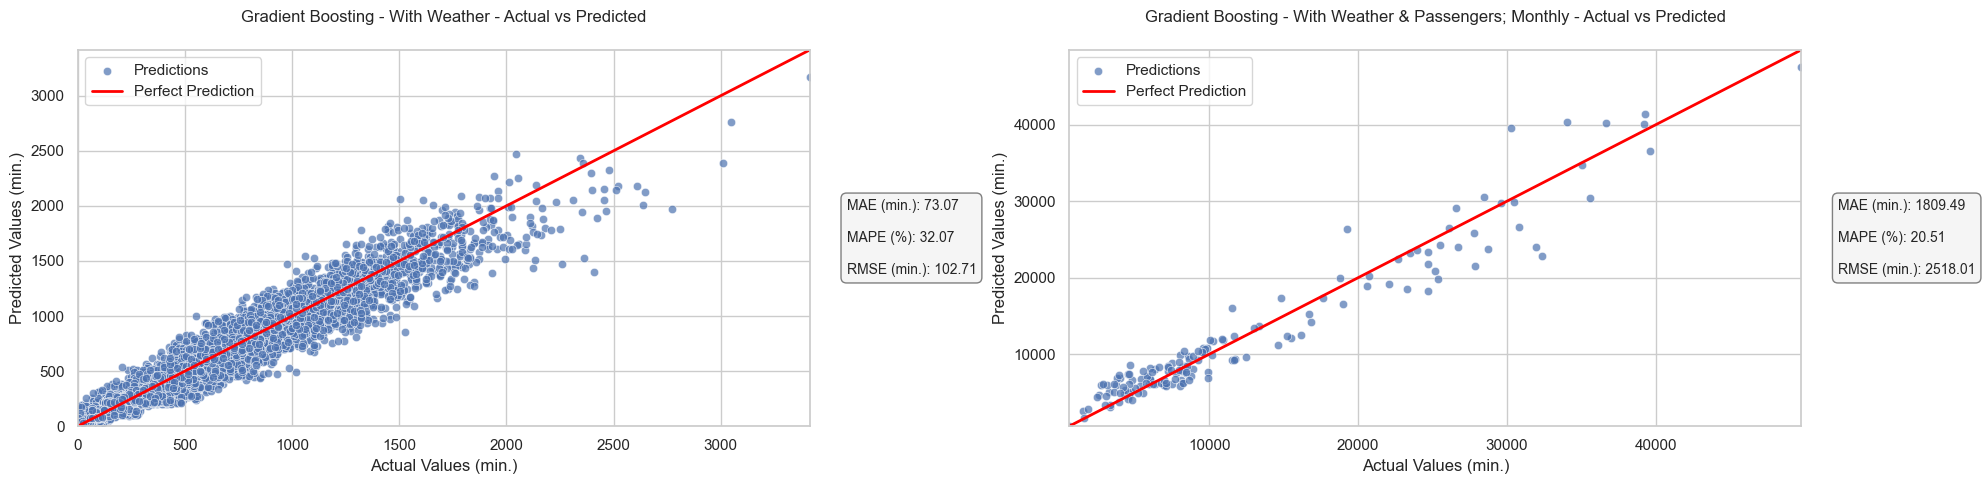

,Dataset,Model,MAE (min.),MAPE (%),RMSE (min.),Mean CV R2,Std CV R2,CV Scores
0,With Weather,Gradient Boosting,73.07,32.07,102.71,0.930287,0.001834,"[0.9288840880516298, 0.9311033806648199, 0.933..."
1,With Weather & Passengers; Monthly,Gradient Boosting,1809.49,20.51,2518.01,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."


In [24]:
gbm_summary, gbm_metrics, gbm_models = modelling_summary(rf_dataframes, rf_titles, ["Gradient Boosting"])
evaluation_results.append({"Model": "Gradient Boosting", **gbm_metrics["With Weather & Passengers; Monthly"]["Gradient Boosting"]})
gbm_summary

#### **1.6. XGBoost**

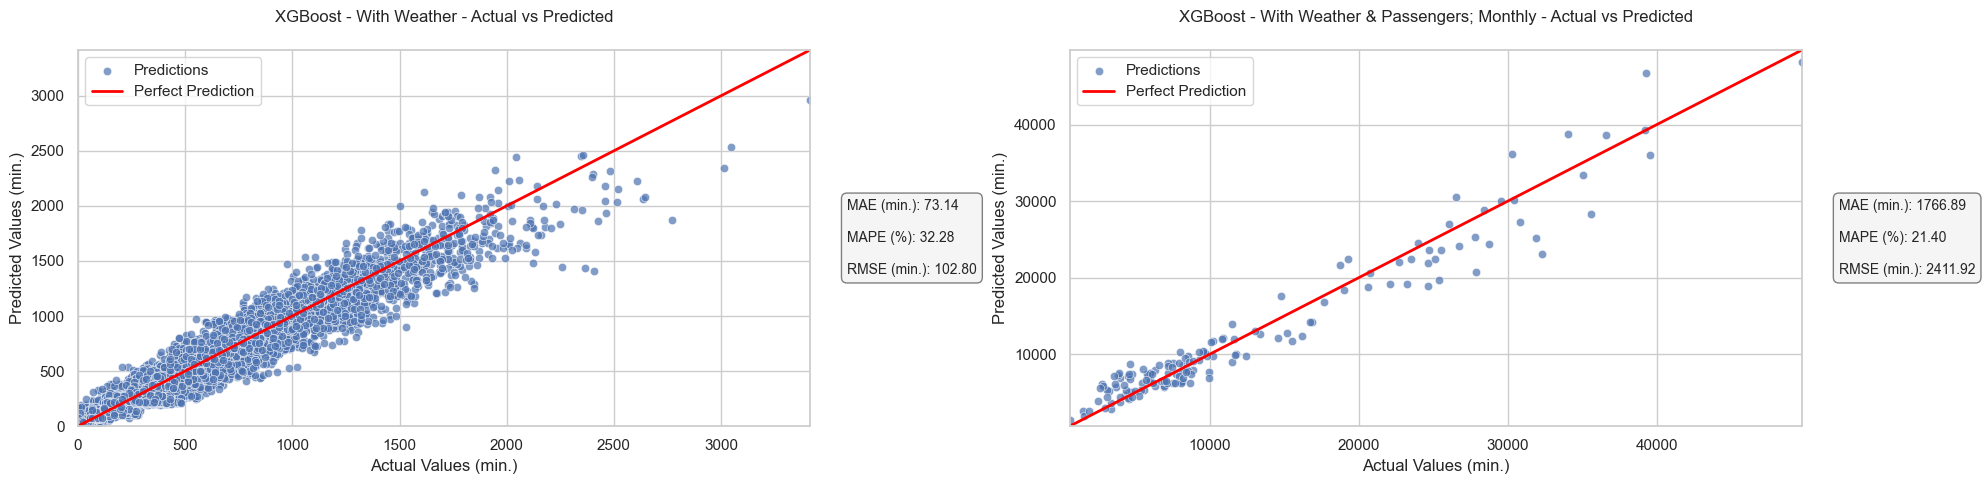

,Dataset,Model,MAE (min.),MAPE (%),RMSE (min.),Mean CV R2,Std CV R2,CV Scores
0,With Weather,XGBoost,73.14,32.28,102.80,0.930287,0.001834,"[0.9288840880516298, 0.9311033806648199, 0.933..."
1,With Weather & Passengers; Monthly,XGBoost,1766.89,21.40,2411.92,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."


In [25]:
xgboost_summary, xgboost_metrics, xgboost_models = modelling_summary(rf_dataframes, rf_titles, ["XGBoost"])
evaluation_results.append({"Model": "XGBoost", **xgboost_metrics["With Weather & Passengers; Monthly"]["XGBoost"]})
xgboost_summary

#### **1.7. Neural Networks**

##### **Min-Max Scaling**
**Purpose**: To scale features so that they lie within a specific range, typically [0, 1] or [-1, 1].

**How it works**: The formula for normalization is:

    Xnorm = (X − Xmin) / (Xmax - Xmin)

where:

    X is the feature value,
    Xmin is the minimum value of the feature,
    Xmax is the maximum value of the feature.

**When to use**:
* To bound features to a specific range, especially if the model is sensitive to the magnitude of the input values, like neural networks or k-NN.
* It is sensitive to outliers, as the presence of extreme values can skew the results.

In [ ]:
evaluation_results = []
shap_results = []

dataframes = [
    #(df_scaled_original, target_variable_original),
    #(df_scaled_weather, target_variable_weather),
    (df_scaled_passengers, target_variable_passengers),
    (df_scaled_BRU_MAD, target_variable_BRU_MAD)
]
titles = ["With Weather & Passengers; Monthly", "BRU-MAD With Weather"] # "Original Data", "With Weather", 

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ((x_standardized, y), title) in enumerate(zip(dataframes, titles)):
    print(f"Current Dataset: {title}")
    print(f"x_standardized shape: {x_standardized.shape}")
    nn = NeuralNetworks(x_standardized, y)
    nn_model, x_test, nn_actual, nn_predictions, nn_metrics = nn.neural_networks(x_standardized, y)
    nn_plots(axes, i, nn_actual, nn_predictions, title, nn_metrics)
    shap_results.append((nn_model, x_test, title))
    evaluation_results.append({"Model": f"Neural Network {title}", **nn_metrics})
    
plt.tight_layout()
plt.show()

# Generate SHAP explanations
for nn_model, x_test, title in shap_results:  # Fix: Store x_test instead of nn_actual
    print(f"Generating SHAP explanations for: {title}")
    NeuralNetworks.explain_lstm(nn_model, x_test)  # Fix: Pass x_test instead of nn_actual

In [7]:
evaluation_results

[{'Model': 'Neural Network With Weather & Passengers; Monthly',
  'MAE (min.)': 2907.33,
  'MAPE (%)': 100.02,
  'RMSE (min.)': 3391.0},
 {'Model': 'Neural Network BRU-MAD With Weather',
  'MAE (min.)': 10.64,
  'MAPE (%)': 64.88,
  'RMSE (min.)': 13.91}]

### **2. Statistical Time-Series Models**

#### **2.1. ARIMA**

ARIMA (AutoRegressive Integrated Moving Average) is a statistical model suited for time series data. If the dataset has time-related features (like delays or flight frequencies over time), ARIMA can be used to predict future values.

* **Prepare Time Series Data**: Ensure the data is sorted by time. Create a dataset with a single time-dependent feature (e.g., delays, flight counts).
* **Build ARIMA Model**: Fit the model by using statsmodels.
    * p = AutoRegressive part (AR, **Auto Regressive** timeseries forecasting model)
    * d = Differencing (I, **Integrated**)
    * q = Moving Average part (MA, **Moving Average**)


**Regression**. We are trying to predict something based on other things. 

**Auto Regression**. We are trying to predict something based on its past values. There could be some pattern in our historical data, and if we can capture that pattern, we can get a much stronger prediction.
* Data we are trying to predict.
    * $f_t$ = Quantity of delayed flights this month.
* Data available to predict $f_t$ with => **Lags**.
    * $f_{t-1}$ = Quantity of delayed flights last month.
    * $f_{t-12}$ = Quantity of delayed flights 12 months ago.

The model should not include every single lag (from 1 to 12) because it will get a lot of statistical issues such as overfitting. That's why we need to figure out which lags are important. How? **PACF chart** (Partial Auto Correlation Function). The model should only include the lags whose direct effects are high either positive or negative. If they are 0 or close to 0, they should not be included. Because they don't have a direct correlation with delays.

e.g. $f_{t-3}$ => direct effect on $f_{t}$ and this means it removes the effect of $f_{t-1}$ and $f_{t-2}$ the delays 1 and 2 months ago.

* $avgf_t$ = Average delayed flights this month.
* $avgf_{t-1}$ = Average delayed flights 1 month ago.
* $avgf_{t-2}$ = Average delayed flights 2 months ago.

* **ACF chart (Auto Correlation Function)**: Takes into account both the direct and indirect effects. With ACF might seem like a good predictor since the pearson correlation is high. But it might be high because of the indirect effects and therefore the direct effect has little to no correlation.
    * E.g. corr($avgf_{t-2}$, $avgf_t$) 
        * Direct: $avgf_{t-2}$ => $avgf_t$
        * Indirect: $avgf_{t-2}$ => $avgf_{t-1}$ => $avgf_t$


* **PACF chart (Partial Auto Correlation Function)**: Only takes into account the direct effect. Why? To see whether the delayed flights on $avgf_{t-2}$ is a good predictor of $avgf_t$. 

**Integrated**: Used to remove trends and make the data stationary. Instead of predicting the **time series** itself, the model predicts **differences of the time series**, from one timestamp to the previous timestamp. This is done by creating a time series **$z_t = a_{t+1} - a_t$** which takes the number of delayed flights in one month - the number of delayed flights from the previous month.

**Moving Average**: **$\hat{f_t} = u + o_1 e_{t-1}$** => Predicted number of flights ($\hat{f_t}$) = mean (u) + coefficient ($o_1$) * the error from the previous month ($e_t$).
* u = constant (every month we have the same amount of delayed flights)
* $f_t$ = changes (how many delayed flights we should have had that month)
* $o_1$ = some coefficient (such as 0.5)
* $e_t(u_e, o_e)$ = the error (the wrong amount delayed flights (mean of the error, standard deviation of the error))

e.g. 10($\hat{f_t}$) -2($e_t$) = 8($f_t$) => 10 + (-2($e_t$) / 2($o_1$)) = 9($\hat{f_t}$) +1($e_t$) = 10($f_t$) => etc.

The model is explaining that we will always have the same amount of delayed flights, but we will adjust that by 50% (coefficient) of whatever the error was last month. We are taking information about how wrong we were in the previous time period (t) to make a better estimate for the current time period (t - 1). We have our average (10), which it's moving around, but it's always centered at the average.

##### **2.1.1. Choosing d (Differencing)**

It's used to make the time series stationary by for example, removing trends and seasonality. 
* Check stationarity with a Dickey-Fuller test. 
    * If the p-value is less than 0.05, the data is likely stationary. (d = 0)
    * If the test result indicates non-stationarity, apply differencing. (d = 1) or (d = 2)
* Determine d:
    * First trying d = 1 (first difference), which is common for time series with a trend.
    * If the data still shows a trend, try d = 2 (second difference), though higher differencing values are rare.

In [15]:
train_end = datetime(2023, 6, 30)
test_end = datetime(2023, 12, 31)
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

df_arima = df_BRU_MAD_daily[['Date', 'total_dep_delay']].copy()
df_arima['Date'] = pd.to_datetime(df_arima['Date'])
df_arima = df_arima.sort_values(by='Date')

time_series_analysis = TimeSeriesAnalysis(df_arima, start_date, end_date, train_end, test_end, column='total_dep_delay')
differenced_data, is_stationary = time_series_analysis.check_stationarity()

if is_stationary:
    print("The data is stationary and ready for modeling.")
else:
    print("The data is still non-stationary after differencing.")

- ADF Test p-value (original): 0.0002712540180082838
Series is stationary after 0 differencing -> d = 0.
The data is stationary and ready for modeling.


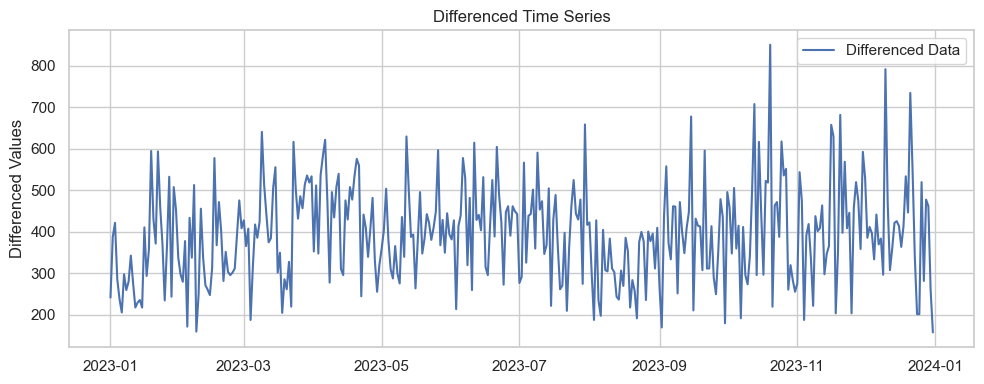

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(differenced_data, label='Differenced Data')
plt.title("Differenced Time Series")
plt.ylabel("Differenced Values")
plt.legend()
plt.tight_layout()
plt.show()


##### **2.1.2. Choosing p (AR Order) and q (MA Order)**

The best practice is to start with a small p and q, and gradually increase them.

**Autoregressive (AR) order (p).**
* AR it's the relationship between the current observation and previous observations.
* This can be determined by analyzing the Partial Autocorrelation Function (PACF) plot.
    * If the PACF plot cuts off at some lag, this could be an estimation for p. (p = cutoff lag at PACF)

**Moving Average (MA) order (q).**
* MA  it's the relationship between the current observation and the residual errors from previous time steps.
* This can be determined by analyzing the Autocorrelation Function (ACF) plot.
    * If the ACF plot cuts off at a certain lag, it suggests that lag as the possible q. (q = cutoff lag at ACF)

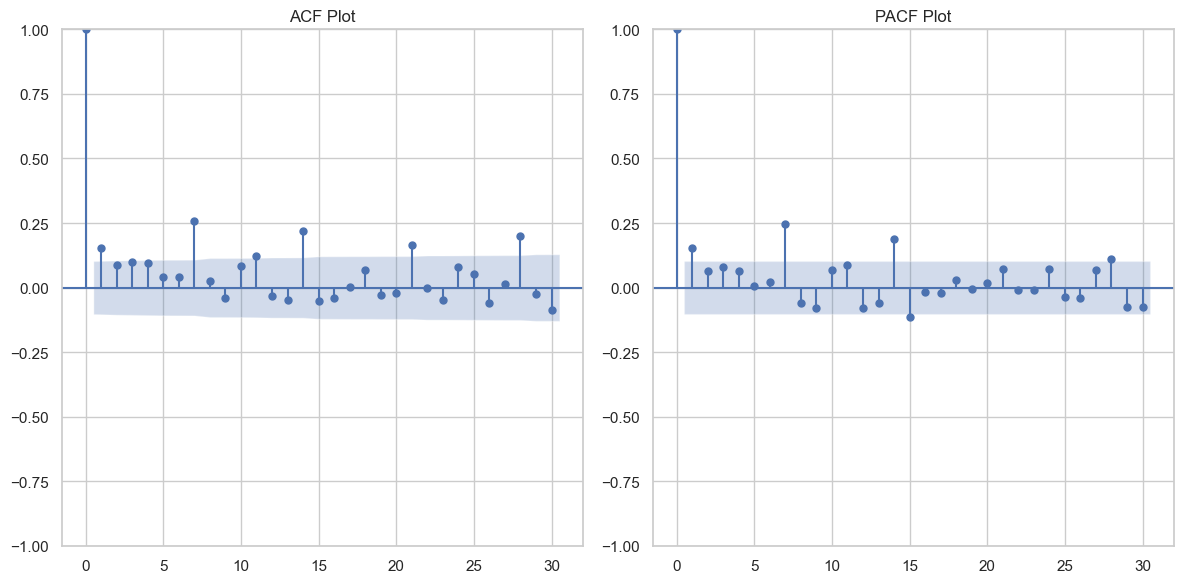

In [17]:
time_series_analysis.plot_acf_pacf(30, 30) # pacf lags need to be less than half of the total observations (12) 11, 5
plt.show()

ACF Plot: This plot shows the correlation between the series and its lags.
* The cutoff point indicates the value for q, the order of the MA term (Moving Average). Where the autocorrelation becomes negligible (near zero). 
* If the ACF decays slowly, this suggests a higher order for q. If it cuts off sharply after a few lags, suggests a lower order for q.

PACF Plot: This plot shows the partial correlation of the series with its lags, controlling for the effect of earlier lags.
* Look for the cutoff point in the PACF plot. The lag where the PACF cuts off suggests the AR order (p).
* If the PACF cuts off after lag k, this suggests that p = k (i.e., the AR model only needs k previous values).
* If the PACF decays gradually, you may need a higher order for p.

##### **2.1.3. Fitting the ARIMA Model**

* d=0, it means no differencing has been applied to the data, and therefore the original data is considered stationary. 
* Even if the data is stationary based on the ADF test, some residual trend could still cause problems for the AR and MA parameter estimation when d=0.

                               SARIMAX Results                                
Dep. Variable:        total_dep_delay   No. Observations:                  181
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1095.133
Date:                Fri, 07 Feb 2025   AIC                           2202.265
Time:                        11:23:57   BIC                           2221.456
Sample:                    01-01-2023   HQIC                          2210.046
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        395.8828     14.264     27.753      0.000     367.925     423.841
ar.L1         -0.0014     92.134  -1.57e-05      1.000    -180.580     180.577
ar.L2          0.5685     69.467      0.008      0.9

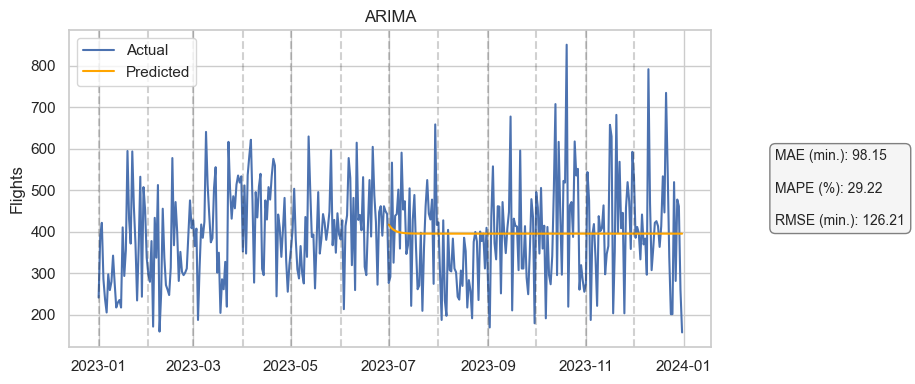

In [18]:
arima_model, arima_test_data, arima_predictions, arima_residuals, arima_metrics = time_series_analysis.arima_sarimax_forecast(order=(2, 0, 2)) #3, 1, 3 or 2, 1, 3

# Store results
evaluation_results.append({"Model": "ARIMA", **arima_metrics})

**Warning [2]. Covariance matrix is singular or near-singular.**
* Some parameters might be highly correlated.
* The model may have overfitting.
* The dataset doesn't have enough observations to support the model's complexity.

**our_model.mle_retvals** provides detailed information about the **Maximum Likelihood Estimation (MLE)** process for ARIMA.
* fopt: The optimized objective function value. This value looks **reasonable** and suggests that the model minimized the likelihood function **successfully**.
* gopt: The gradient of the objective function at the solution. The values are **close to zero**, indicating a **good fit** at the optimization's end.
* fcalls: The number of function calls made. A high number, combined with a failure to converge, indicates **the optimizer struggled to find a solution**.
* warnflag: A warning flag indicating the status of the optimization:
    * **0: Convergence was successful.**
    * 1: Maximum iterations were exceeded.
    * 2: Other issues prevented convergence.
* converged: A boolean flag indicating whether the optimization converged. True confirms that **convergence was achieved**.
* iterations: The number of iterations performed by the optimizer. The optimizer stopped because it found a solution (111) before reaching the maxiter limit (500).

#### **2.2. SARIMAX**
SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) models seasonality in time series data. A "seasonal cycle" refers to a full repetition of a pattern in your time series data. The S ((P, D, Q, S)) is the seasonal period or "Seasonal Order".

SARIMAX is more suitable for datasets with additional features compared to ARIMA. It can include exogenous variables (X) to improve predictions.

It needs at least two full seasonal cycles. If there is not enough past data covering multiple seasonal cycles, the model cannot learn the pattern properly. This leads to warnings like: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA.

E.g. If the dataset follows a yearly pattern...
- One seasonal cycle = 12 months            => S = 12. 
- Two full cycles = 24 months (2 years)     => At least 2 × S observations. 



                                     SARIMAX Results                                      
Dep. Variable:                    total_dep_delay   No. Observations:                  181
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 30)   Log Likelihood                -944.263
Date:                            Fri, 07 Feb 2025   AIC                           1898.526
Time:                                    11:24:01   BIC                           1913.612
Sample:                                01-01-2023   HQIC                          1904.655
                                     - 06-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6050      0.221      2.738      0.006       0.172       1.038
ma.L1         -0.3475      0.268   

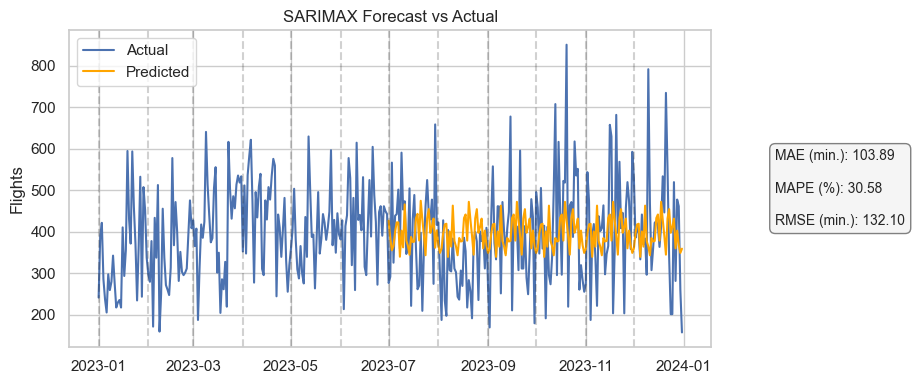

In [19]:
#sarimax_analysis = TimeSeriesAnalysis(df_BRU_MAD_daily, start_date, end_date, train_end, test_end, column='total_dep_delay')
sarimax_model, sarimax_test_data, sarimax_predictions, sarimax_residuals, sarimax_metrics = time_series_analysis.arima_sarimax_forecast(order=(1, 0, 1), seasonal_order=(1, 1, 1, 30))

# Store results
evaluation_results.append({"Model": "SARIMAX", **sarimax_metrics})

#### **2.3. Rolling Forecast Origin**
Instead of trying to predict 30 or more days right away, it predicts just one, and then it takes into account its real value, and then it predicts the nest one, and so on.

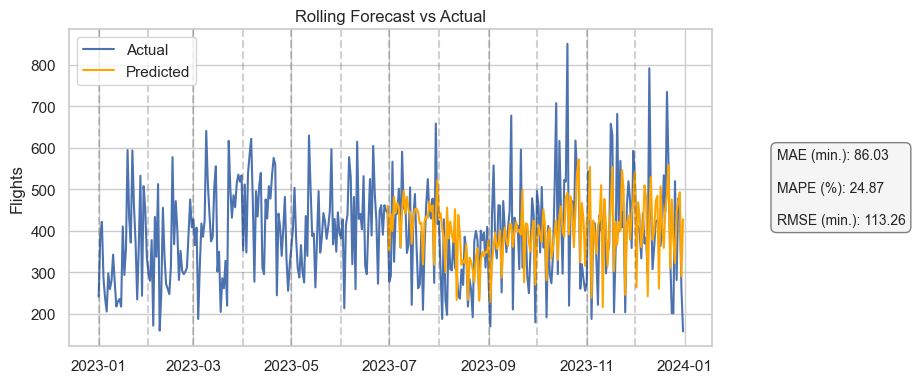

In [20]:
rolling_actual, rolling_predictions, rolling_residuals, rolling_metrics = time_series_analysis.rolling_forecast(order=(1, 1, 1), train_window=180, seasonal_order=(0, 1, 1, 7))

# Store results
evaluation_results.append({"Model": "Rolling Forecast", **rolling_metrics})

#### **2.4. Prophet**

Prophet data range: 2023-01-01 00:00:00 - 2023-12-31 00:00:00
Train data range: 2023-01-01 00:00:00 - 2023-06-30 00:00:00 (181 rows)
Test data range: 2023-07-01 00:00:00 - 2023-12-31 00:00:00 (184 rows)


11:24:35 - cmdstanpy - INFO - Chain [1] start processing
11:24:35 - cmdstanpy - INFO - Chain [1] done processing


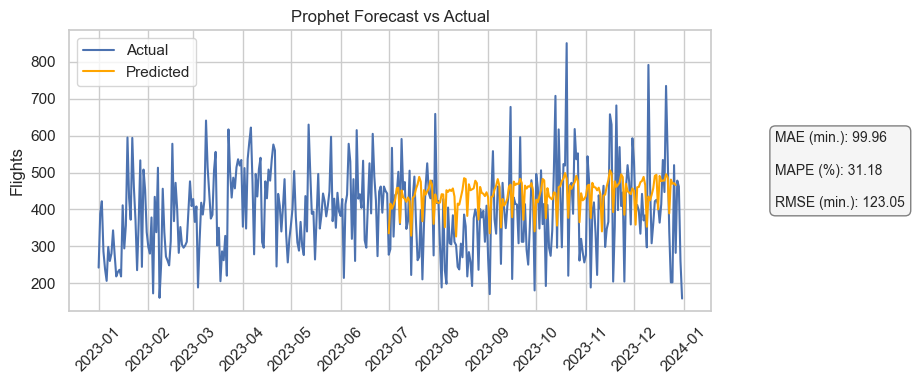

In [21]:
prophet_predictions, prophet_residuals, prophet_metrics = time_series_analysis.prophet_forecast(periods=180, frequency='D')

# Store results
evaluation_results.append({"Model": "Prophet", **prophet_metrics})

### **3. Learning Curve Pipeline**


To align the structure of the data for ARIMA/SARIMAX with models like Random Forest and Linear Regression, aggregate the data by date.
* Aggregate delays across all flights on the same day (e.g., mean, sum, or median of delays).
* Include additional features like total flights, average delays, and weather summaries for each day.

Hyperparameter Tuning: Helps to identify the best combination of hyperparameters that optimize model performance. 

1. **Grid Search CV**. Tests all combinations.
        
**Candidates**. It systematically tries every possible combination of the parameters in the provided param_grid. Since param_grid_rf has four hyperparameters:
- n_estimators: 3 options
- max_depth: 4 options
- min_samples_split: 3 options
- min_samples_leaf: 3 options

There are *3 x 4 x 3 x 3 = 108* possible combinations.

**Total Fits**. With 5-fold cross-validation (cv=5), Grid Search will evaluate each of the combinations 5 times, leading to a total of *108 x 5 = 540* fits.
        
2. **Randomized Search CV**. Tests random samples.
    
**Candidates**. Randomized Search doesn’t try all combinations but instead samples a subset from the provided parameter space. In this case: n_iter = 10
        
Meaning it will randomly sample *10* different combinations from the parameter grid.

**Total Fits**. With 5-fold cross-validation, Randomized Search will evaluate each of the combinations 5 times, resulting in *10 x 5 = 50* total fits.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from avstats.core.ML.ModelEvaluation import evaluate_model, cross_validate
from avstats.core.ML.ModelTraining import ModelTraining

def modelling_summary(dataframes, titles, models_to_train, param_grids=None):
    """
    Train and evaluate multiple models on different datasets, including hyperparameter tuning and learning curves.

    Parameters:
    - dataframes: List of tuples [(DataFrame, str)], each containing the dataset and target column name.
    - titles: List of titles corresponding to the datasets.
    - models_to_train: List of model names as keys from the `ModelTraining.models` dictionary.
    - param_grids: Dictionary with hyperparameter grids for each model (optional).

    Returns:
    - pd.DataFrame: DataFrame containing the model summaries.
    - dict: Simplified dictionary with only the key metrics (MAE, MAPE, RMSE) for each model and dataset.
    - dict: Dictionary containing the best model for each dataset (based on RMSE).
    """
    num_plots = len(dataframes) * len(models_to_train)
    rows = (num_plots + 1) // 2
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(24, rows * 6)) 
    axes = axes.flatten()

    learning_fig, learning_axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
    learning_axes = learning_axes.flatten()

    model_summaries = []
    metrics_summary = {}
    final_models = {}
    plot_idx = 0

    for i, ((df, column), title) in enumerate(zip(dataframes, titles)):
        try:
            # Prepare features and target
            x = df.drop(columns=[column])
            y = df[column]
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
            model_training = ModelTraining(x_train, y_train, x_test, y_test)

            dataset_metrics = {}
            final_model_name = None
            final_rmse = np.inf
            final_trained_model = None

            for model_name in models_to_train:
                model_function = model_training.models[model_name]

                # Hyperparameter tuning
                if param_grids and model_name in param_grids:
                    param_grid = param_grids[model_name]
                    model, _ = model_function()
                    search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
                    search.fit(x_train, y_train)
                    best_params = search.best_params_
                    trained_model = search.best_estimator_
                    predictions = trained_model.predict(x_test)
                
                elif model_name == "Linear Regression":
                    trained_model = LinearRegression()
                    trained_model.fit(x_train, y_train)
                    predictions = trained_model.predict(x_test)  # Ensure predictions exist
                    best_params = "Default"
                    model_training.train_linear_model()

                else:
                    trained_model, predictions = model_function()
                    best_params = "Default"

                # Evaluate the model
                residuals = y_test - predictions
                metrics = evaluate_model(y_test, predictions, residuals)

                # Store simplified metrics
                dataset_metrics[model_name] = {
                    "MAE (min.)": metrics["MAE (min.)"],
                    "MAPE (%)": metrics["MAPE (%)"],
                    "RMSE (min.)": metrics["RMSE (min.)"],
                }

                # Determine best model
                if metrics["RMSE (min.)"] < final_rmse:
                    final_rmse = metrics["RMSE (min.)"]
                    final_model_name = model_name
                    final_trained_model = trained_model

                # Plot results
                ax = axes[plot_idx]
                model_training.plot_model(title=f"{model_name} - {title}", evaluation_metrics=metrics, ax=ax)

                # Cross-validation
                cv_scores = cross_validate(x_train, y_train)

                # Store results for summaries
                model_summary = {
                    "Dataset": title,
                    "Model": model_name,
                    "Best Params": best_params,
                    "MAE (min.)": metrics["MAE (min.)"],
                    "MAPE (%)": metrics["MAPE (%)"],
                    "RMSE (min.)": metrics["RMSE (min.)"],
                    "Mean CV R2": cv_scores.mean(),
                    "Std CV R2": cv_scores.std(),
                    "CV Scores": cv_scores.tolist(),
                }
                model_summaries.append(model_summary)

                # Learning Curve
                train_sizes, train_scores, test_scores = learning_curve(
                    trained_model, x_train, y_train, cv=5, scoring="neg_mean_squared_error", 
                    train_sizes=np.linspace(0.1, 1.0, 10)
                )

                train_mean = -np.mean(train_scores, axis=1)
                test_mean = -np.mean(test_scores, axis=1)
                
                # Plot Learning Curve
                learning_ax = learning_axes[plot_idx]
                learning_ax.plot(train_sizes, train_mean, label="Training Score", color="blue")
                learning_ax.plot(train_sizes, test_mean, label="Validation Score", color="orange")
                learning_ax.set_title(f"Learning Curve: {model_name} - {title}")
                learning_ax.set_xlabel("Training Size")
                learning_ax.set_ylabel("Error")
                learning_ax.legend()
                
                plot_idx += 1

            # Save best model for this dataset
            final_models[title] = {
                "Model Name": final_model_name,
                "Trained Model": final_trained_model,
                "Best RMSE": final_rmse
            }
            metrics_summary[title] = dataset_metrics

        except KeyError as e:
            print(f"Skipping DataFrame {i} due to missing column: {e}")

    # Hide unused axes
    for ax in axes[plot_idx:]:
        ax.set_visible(False)

    for ax in learning_axes[plot_idx:]:
        ax.set_visible(False)

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()
    learning_fig.tight_layout()
    plt.show()

    # Convert model summaries to a DataFrame
    model_summary_df = pd.DataFrame(model_summaries)
    return model_summary_df, metrics_summary, final_models

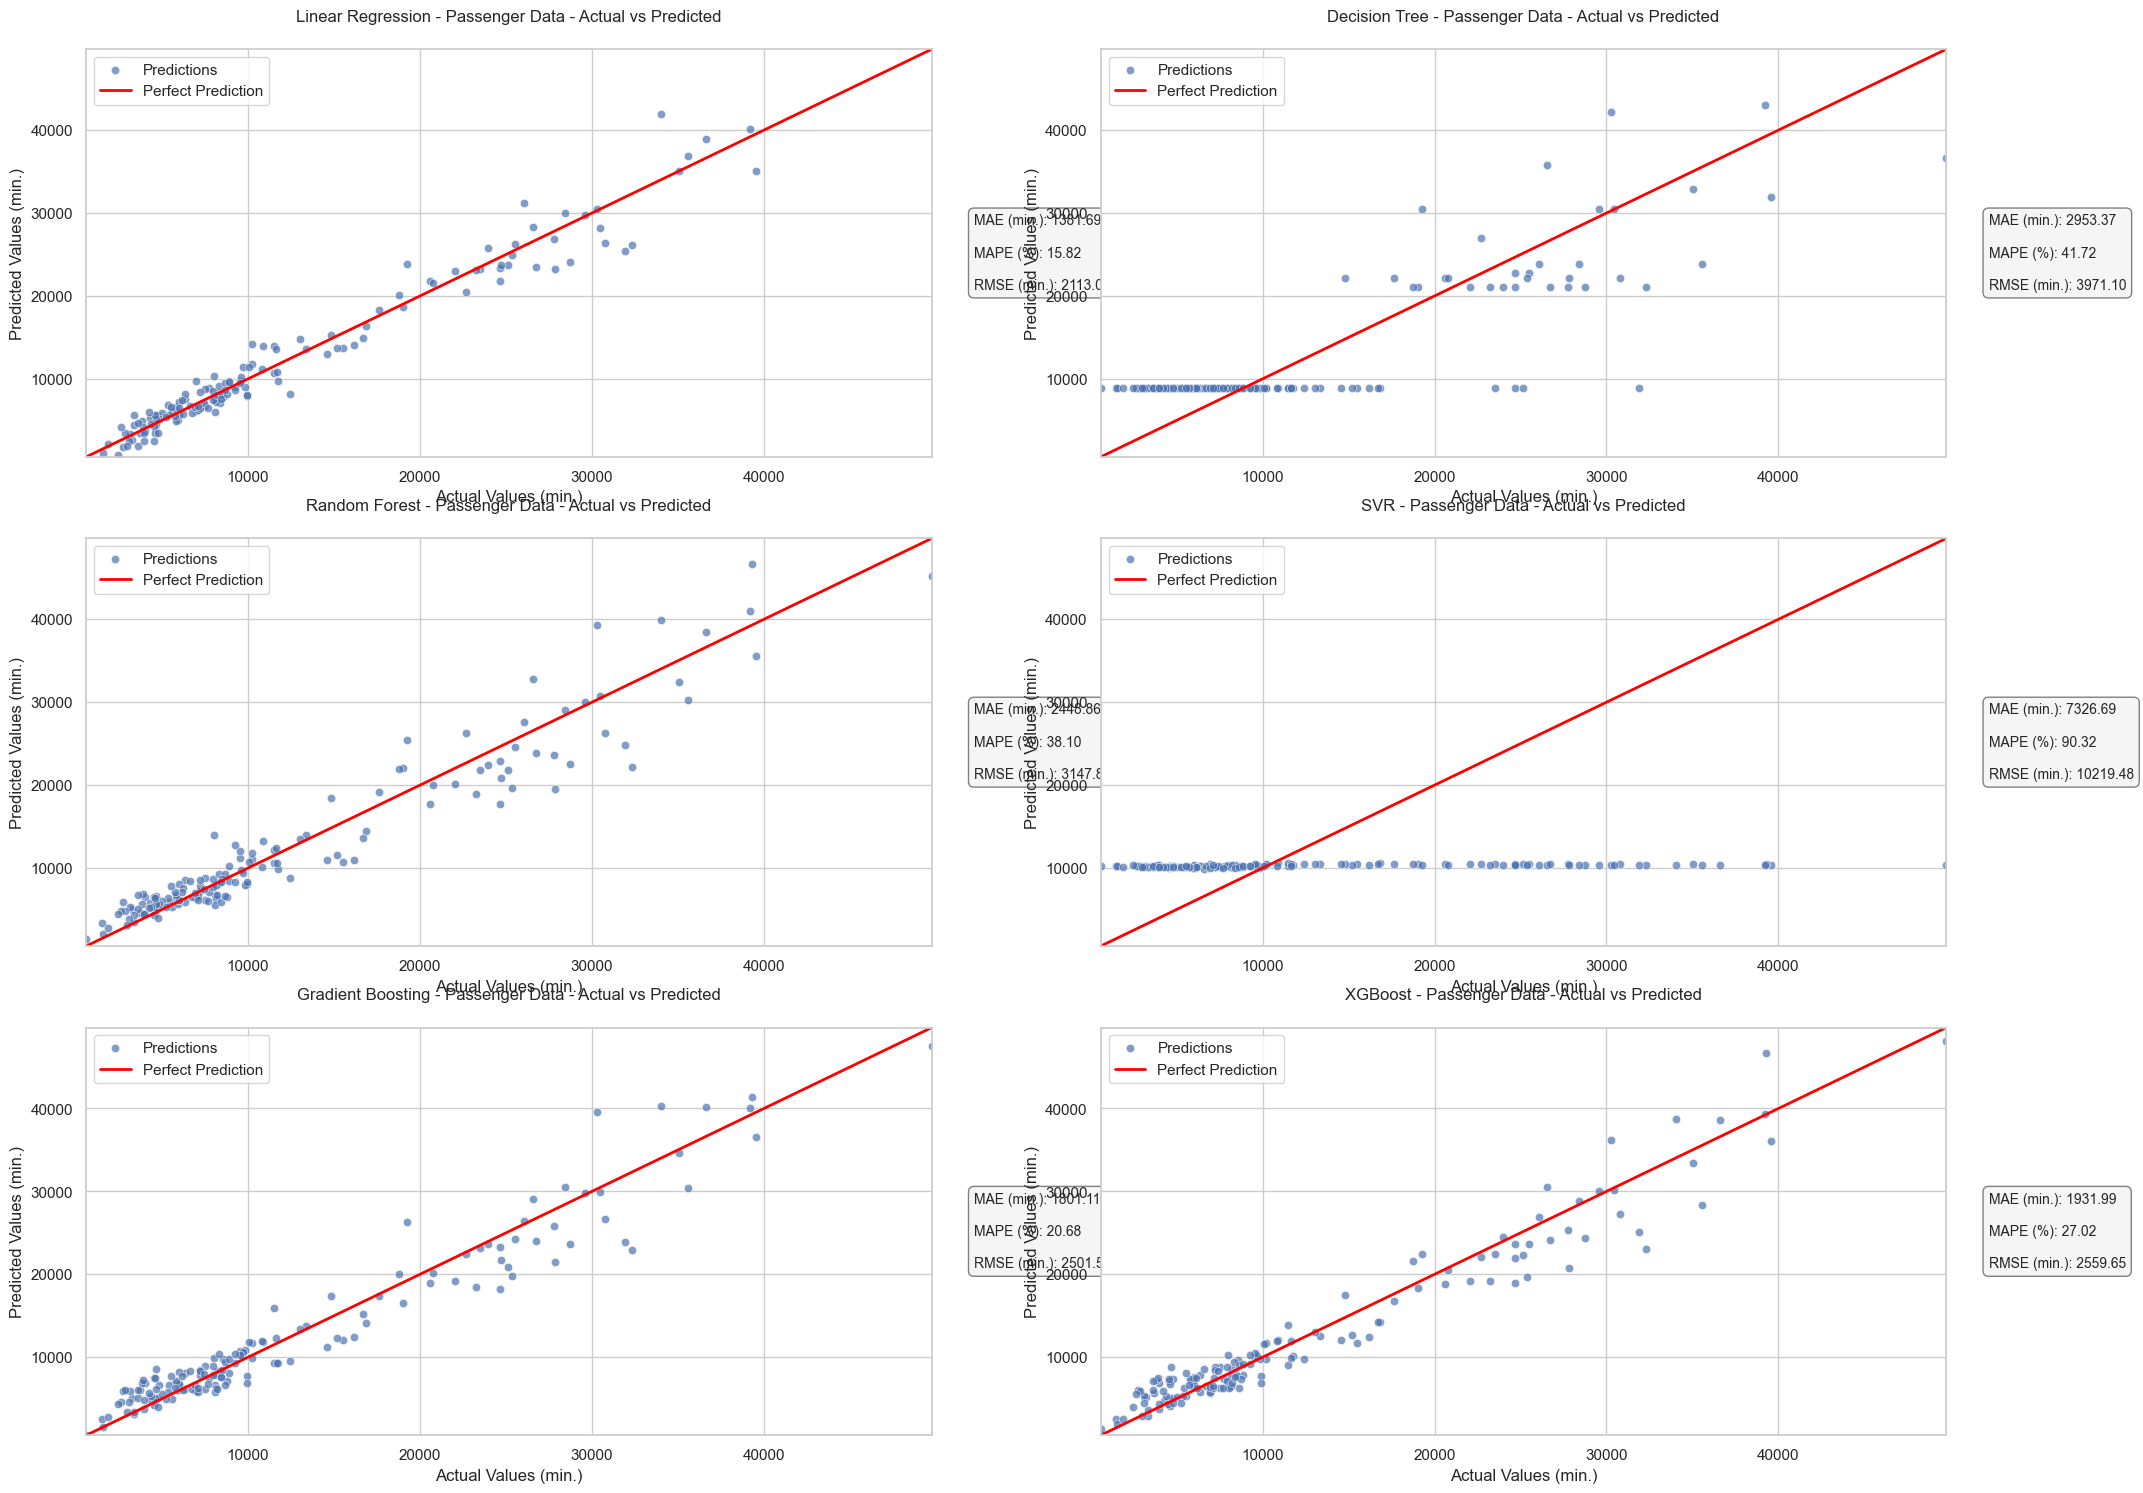

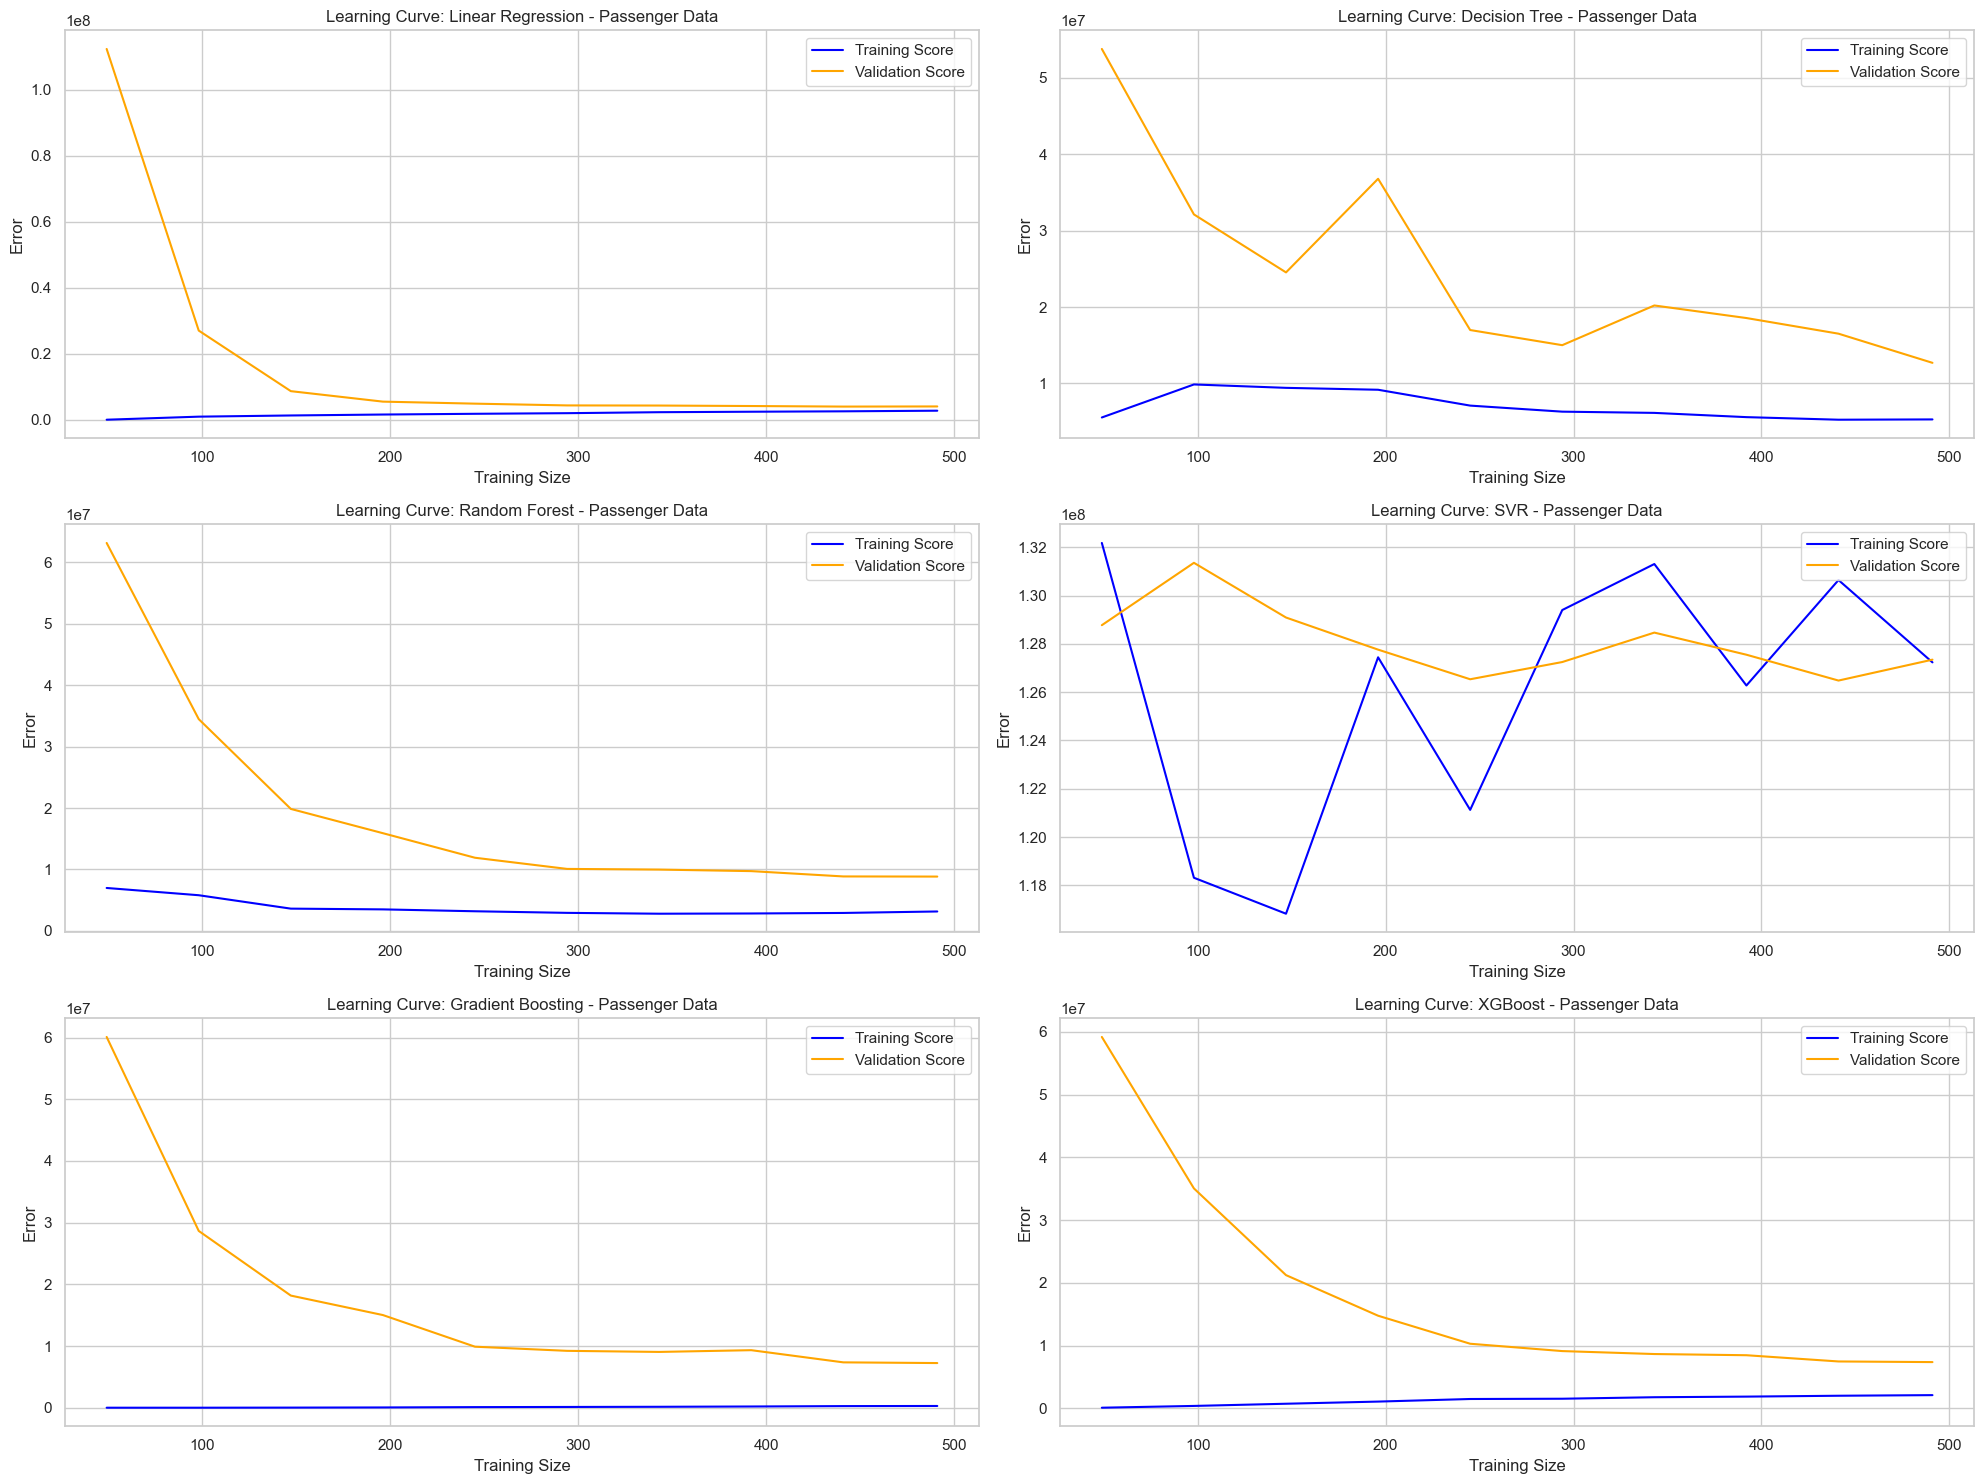

,Dataset,Model,Best Params,MAE (min.),MAPE (%),RMSE (min.),Mean CV R2,Std CV R2,CV Scores
0,Passenger Data,Linear Regression,Default,1381.69,15.82,2113.00,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
1,Passenger Data,Decision Tree,"{'max_depth': 10, 'min_samples_split': 10}",2953.37,41.72,3971.10,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
2,Passenger Data,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",2448.86,38.10,3147.84,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
3,Passenger Data,SVR,"{'C': 10, 'gamma': 'scale'}",7326.69,90.32,10219.48,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
4,Passenger Data,Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 100}",1801.11,20.68,2501.55,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
5,Passenger Data,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1931.99,27.02,2559.65,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."


In [28]:
# Define hyperparameter grids
param_grids = {
    "Decision Tree": {"max_depth": [5, 10], "min_samples_split": [2, 5, 10]},
    "Random Forest": {"n_estimators": [50, 100], "max_depth": [10]}, 
    "SVR": {"C": [0.1, 1, 10], "gamma": ["scale", "auto"]},
    "Gradient Boosting": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]},
    "XGBoost": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1], "max_depth": [3, 5]},
}

# Train models with hyperparameter tuning
model_summary_df, metrics_summary, final_models = modelling_summary(
    dataframes=[(df_filtered_passengers, "total_dep_delay")],
    titles=["Passenger Data"],
    models_to_train=["Linear Regression", "Decision Tree", "Random Forest", "SVR", "Gradient Boosting", "XGBoost"],
    param_grids=param_grids
)

display(model_summary_df)

Blue Curve (Training Score):
* Shows how the model performs on the training set. Usually, this error is low for large training sizes because the model fits the training data well.

Orange Curve (Validation Score):
* Shows how well the model generalizes to unseen data. Ideally, this error decreases as the training size increases and stabilizes, indicating good generalization.


RMSE = **$\sqrt{6000} = 77 min.$**

RMSE = **$\sqrt{1000} = 32 min.$**

### **4. Model Comparisons**

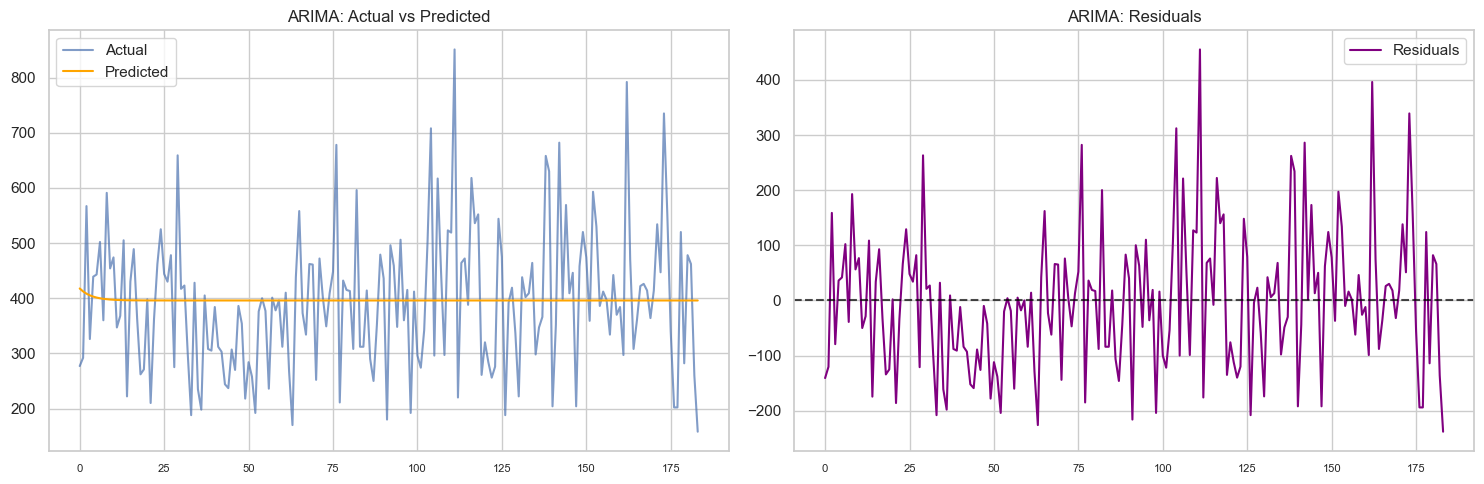

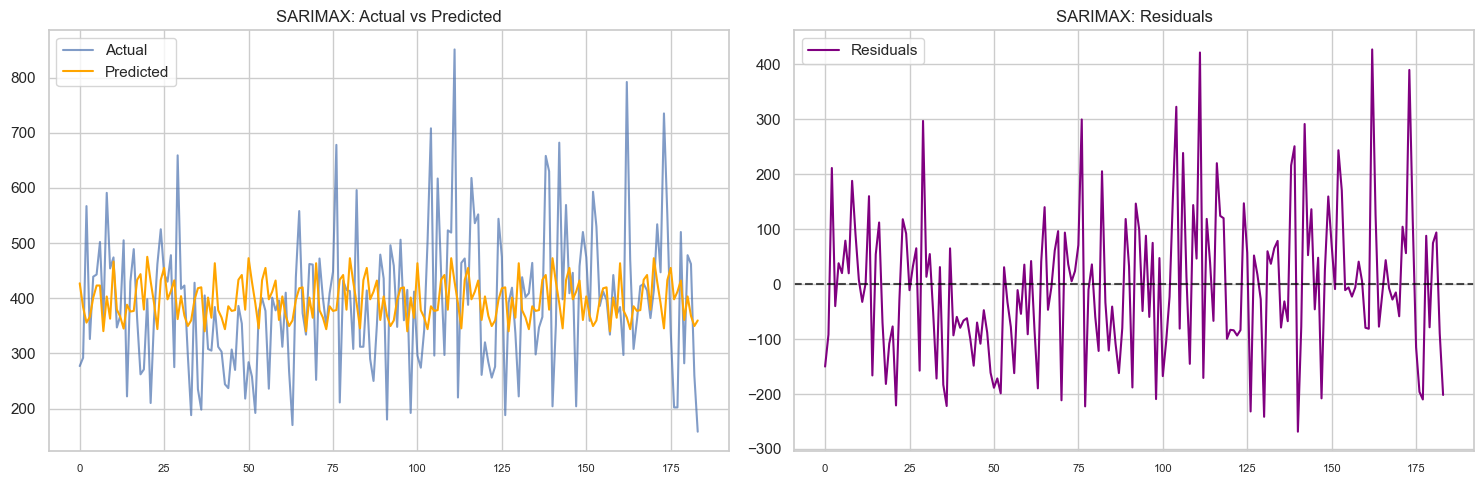

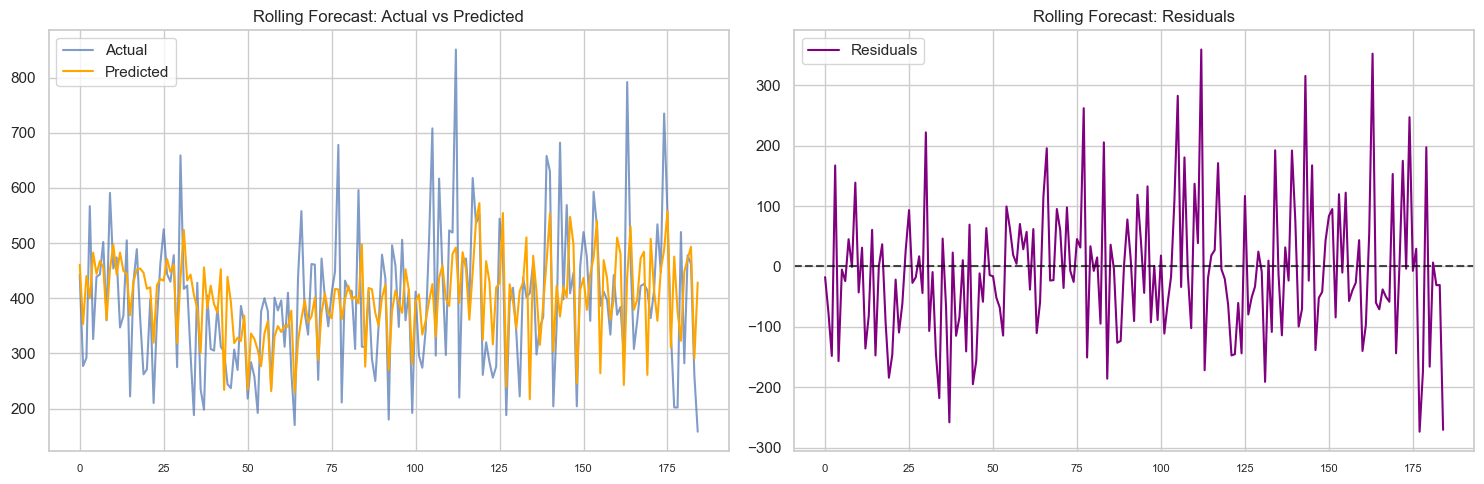

In [22]:
plot_combined("ARIMA", arima_test_data, arima_predictions, arima_residuals)
plot_combined("SARIMAX", sarimax_test_data, sarimax_predictions, sarimax_residuals)
plot_combined("Rolling Forecast", rolling_actual, rolling_predictions, rolling_residuals)

# Combine Results into a DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

In [23]:
evaluation_df

,Model,MAE (min.),MAPE (%),RMSE (min.)
0,Linear Regression,515.31,21.42,701.65
1,Decision Tree,678.64,26.97,1044.16
2,Random Forest,533.07,18.85,824.10
3,SVR,1229.72,59.01,1963.78
4,Gradient Boosting,468.88,16.58,718.07
5,XGBoost,503.27,17.88,750.86
6,ARIMA,98.15,29.22,126.21
7,SARIMAX,103.89,30.58,132.10
8,Rolling Forecast,86.03,24.87,113.26
9,Prophet,99.96,31.18,123.05


* MAE gives the average error in absolute terms, without considering whether the prediction is too high or too low.
* RMSE penalizes larger errors more than smaller ones due to squaring the errors, making it sensitive to outliers.
* MAPE represents the average percentage error relative to the actual values. Lower MAPE means the model is making smaller relative errors.

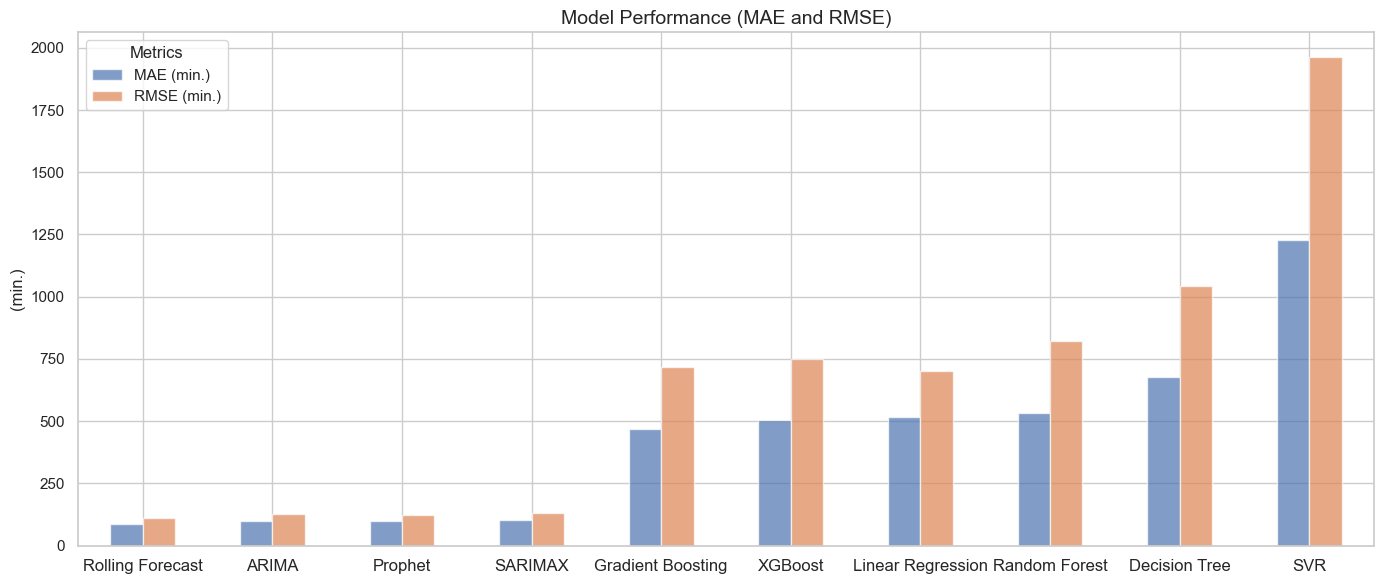

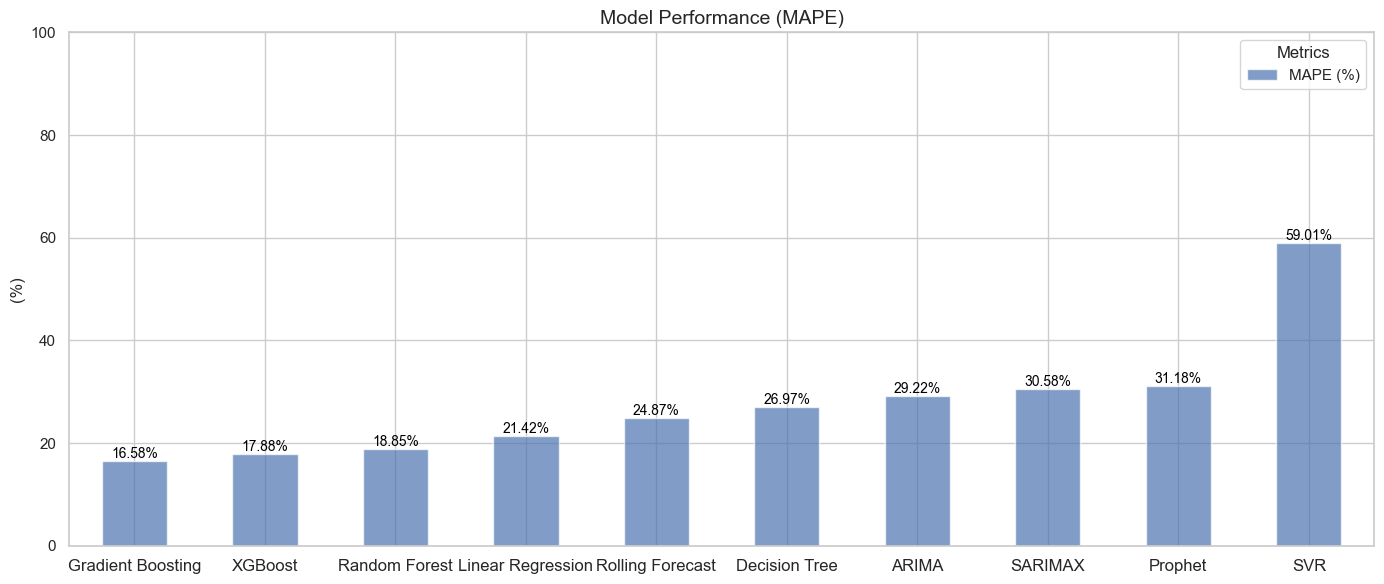

In [24]:
# Separate MAE, RMSE, and MAPE for plotting
evaluation_data = evaluation_df.set_index('Model')

# Plot model performance (metrics)
plot_metrics(evaluation_results)

Predictions for all the routes (using weather data)
* Linear Regression
* Decision Tree
* Random Forest
* Support Vector Regression (SVR)
* Gradient Boosting Machines (GBM)
* XGBoost

Predictions for all the routes (without passenger data)
* Long Short-Term Memory (LSTM)
* Recurrent Neural Networks (RNNs)

Predictions in 1 route (BRU-MAD)
* ARIMA
* SARIMAX
* Rolling Forecast
* Prophet


Answer question: why these models and what learns faster

### **5. Residual Analysis**
* **Calculate residuals**: The differences between the actual and predicted values.
* **Linearity**: They should show no clear pattern when plotted against fitted values.
* **Normality**: They should follow a normal distribution (with Q-Q plot or histogram).
* **Autocorrelation**: They should not show autocorrelation (check with Durbin-Watson or ACF).
* **Homoscedasticity**: They should have constant variance (no funnel shapes).

In [ ]:
"""plt.figure(figsize=(12, 8))  

# Linear Regression - Residual Analysis
linear_res_plot = ResidualAnalysis()
linear_res_plot.plot_residuals("Linear Regression", subplot_position=(2, 2, 1))

# Random Forest - Residual Analysis
random_res_plot = ResidualAnalysis()
random_res_plot.plot_residuals("Random Forest", subplot_position=(2, 2, 2))

plt.tight_layout()
plt.show()"""

In [ ]:
plt.figure(figsize=(12, 6))

linear_res_plot.q_q_normality("Linear Regression", subplot_position=(1, 2, 1))
random_res_plot.q_q_normality("Random Forest", subplot_position=(1, 2, 2))

plt.tight_layout()
plt.ylim(-2000, 4000)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

linear_res_plot.histogram_normality("Linear Regression", subplot_position=(1, 2, 1))
random_res_plot.histogram_normality("Random Forest", subplot_position=(1, 2, 2))

plt.tight_layout()
plt.xlim(-2000, 4000) 
plt.show()